In [693]:
import vitaldb
import numpy as np
import pandas as pd
import scipy.signal as ss
from scipy.ndimage import minimum_filter1d, maximum_filter1d
from scipy.stats import median_absolute_deviation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import json
from tqdm.auto import tqdm


# colorblind friendly palette
import matplotlib as mpl
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']
plt.rcParams['figure.figsize'] = [10, 5]

In [274]:
def createWindows(win_len, fs, N_samp, overlap):
    win_len = win_len * fs
    overlap = np.round(overlap * win_len)
    N_samp = N_samp - win_len + 1
    
    idx_start = np.round(np.arange(0, N_samp, win_len - overlap)).astype(int)
    idx_stop = np.round(idx_start + win_len - 1).astype(int)
    
    return idx_start, idx_stop

In [275]:
def um(ta=None, tb=None, data=[[]], t=[]):
    length = len(data)
    ta = ta if ta else t.min()
    tb = tb if tb else t.max()
    twin = (t >= ta) & (t <= tb)

    plt.figure(dpi=100)
    for i, sig in enumerate(data):
        sig = np.ma.masked_invalid(sig)
        plt.subplot(length,1,i+1)
        plt.plot(t[twin], sig[twin], lw=1, c=cp[i])
        if ta != None:
            plt.xlim(ta, tb)
        plt.tight_layout()
        plt.show()

In [276]:

def find_flat_lines(arr, threshold, type="art"):
    mean = np.mean(arr)
    std = np.std(arr)
    
    #valid_inds = np.where(np.abs(arr) < 3*mean)
    
    # Get the indices of the start and end of each flat line
    start_idx = np.where(np.abs((arr)) > 5)[0] + 1
    end_idx = np.concatenate(([0], start_idx[:-1]))
        

    # Compute the length of each flat line
    flat_line_lengths = start_idx - end_idx

    # Find flat lines longer than the threshold
    long_flat_lines = flat_line_lengths[flat_line_lengths > threshold]

    # Find the length of the longest flat line
    if len(long_flat_lines) > 0:
        longest_flat_line = np.max(long_flat_lines)
    else:
        longest_flat_line = 0

    # Count the number of flat lines longer than the threshold
    num_long_flat_lines = np.sum(flat_line_lengths > threshold)

    return longest_flat_line, num_long_flat_lines

In [277]:
def hampel(x, k=5, t0=3):
    k = k if k % 2 == 1 else k + 1
    med = ss.medfilt(x, k)
    dev = np.abs(x - med)
    mdev = ss.medfilt(dev, k)
    return np.where(dev > t0 * mdev, med, x)

In [278]:
def load_data(vcaseid):    
    track_names = ['ECG_II', 'ART', 'PLETH']
    vf = vitaldb.VitalFile(vcaseid, track_names) 
    data = vf.to_numpy(track_names, 1/fs)
    t = np.arange(data.shape[0]) / fs
    
    art, ppg = data[:, 1], data[:, 2]
    
    return t, art, ppg

In [279]:
def processor_phase1(ppg=[], fs=125, window_size_mult = 10, art = True):
    
    window_size = int(window_size_mult*fs)
    
    ymin = minimum_filter1d(ppg, window_size)
    ymax = maximum_filter1d(ppg, window_size)

    ppgpeaks, _ = ss.find_peaks(ppg,
                                height=(ymax+ymin)/2,
                                prominence=(ymax-ymin)*0.3,
                                distance=fs/3)

    #blood pressure should be reasonable
    if art:
        valid = (ymin > 20) & (ymax < 300)
    else:
        valid = np.ones_like(ymin, dtype=bool)

    #Get the valid peaks here
    yminp, ymaxp = ymin[ppgpeaks], ymax[ppgpeaks]
    ymindiff = np.abs(np.diff(yminp, prepend=yminp[0])) / (ymaxp - yminp)
    ymaxdiff = np.abs(np.diff(ymaxp, prepend=ymaxp[0])) / (ymaxp - yminp)
    valid[ppgpeaks[ymindiff > 0.5]] = False
    valid[ppgpeaks[ymaxdiff > 0.5]] = False

    # Calculate the heart rate from r values
    rri = np.diff(ppgpeaks, prepend=0) / fs
    hr = 60/rri
    rriv = np.abs(np.diff(rri, append=0)) / rri

    # Reasonable heartrate check
    valid[ppgpeaks[hr < 30]] = False
    valid[ppgpeaks[rriv > 0.4]] = False
    
    #return the bit mask 
    return valid    

In [712]:
# Constants
fs = 125
MAX_LENGTH = 1000

nan_threshold = 0.2 #percent
flat_line_threshold = 1E4

In [281]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

In [282]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) &
    set(df_trks[df_trks['tname'] == 'SNUADC/ECG_II']['caseid']) &
    set(df_trks[df_trks['tname'] == 'SNUADC/PLETH']['caseid']) &
    set(df_trks[df_trks['tname'] == 'SNUADC/PLETH']['caseid']) &
    set(df_cases[df_cases['age'] > 18]['caseid']) &
    set(df_cases[df_cases['age'] >= 18]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aneurysm", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aorto", case=False)]['caseid'])& 
    set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
)
print('Total {} cases found'.format(len(caseids)))

Total 3238 cases found


In [283]:
def acceptOrReject(sig, window_size_mult=4, art=True, verbose=False):
    t_len = len(sig)
    
    # NaN check
    num_nans = np.isnan(sig).sum() / t_len * 100
    nan_indices = np.where(~np.isnan(sig))[0] - 1
    nan_lengths = np.diff(np.concatenate(([0], nan_indices, [t_len -1])))
    max_nan_length = np.max(nan_lengths)
    
    #Flat lines check
    window_size = int(window_size_mult*fs)
    ymin = minimum_filter1d(sig, window_size)
    ymax = maximum_filter1d(sig, window_size)
    diff_filt = ymax - ymin
    
    if art:
        threshold = 10
    else:
        threshold = 5
        
    num_flat_regions = np.count_nonzero(diff_filt < threshold)
    
    # # Crazy Signal Test
    # #Get the valid peaks here
    # sigpeaks, _ = ss.find_peaks(sig,
    #                         height=(ymax+ymin)/2,
    #                         prominence=(ymax-ymin)*0.3,
    #                         distance=fs/3)
    # yminp, ymaxp = ymin[sigpeaks], ymax[sigpeaks]
    # ymindiff = np.abs(np.diff(yminp, prepend=yminp[0])) / (ymaxp - yminp)
    # ymaxdiff = np.abs(np.diff(ymaxp, prepend=ymaxp[0])) / (ymaxp - yminp)
    # valid[sigpeaks[ymindiff > 0.8]] = False
    # valid[sigpeaks[ymaxdiff > 0.8]] = False
    
    # num_crazy_samples = np.count_nonzero(valid)
    # num_crazy_samples = 0
    
    first_deriv = np.diff(sig, prepend=sig[0])
    num_flat_samples = np.count_nonzero(np.logical_and(first_deriv == 0, np.abs(sig) == np.max(np.abs(sig))))
    num_flat_samples = 0
    
    if verbose:
        print("Num Flat Regions: ", num_flat_regions)
        print("NaN Percentatge: ", num_nans)
        print("Longest NaN: ", max_nan_length)
        print("Num Flat Samples: ", num_flat_samples)
        print("Sum/Threshold: ", max_nan_length + num_flat_samples + num_flat_regions, 0.1*t_len)
    
    #Final conclusion
    if num_nans < nan_threshold and \
        (max_nan_length + num_flat_samples + num_flat_regions) < 0.05*t_len:
            return True
    
    return False
    
    
    
    
    

In [711]:
# Exclusion Checks
import random
#random_inds = random.sample(range(len(caseids)), MAX_LENGTH)
#random_inds= [3135, 2207, 2122, 2735, 1732]
#random_inds= [1456, 2552, 658, 412, 2615]
random_inds = np.arange(MAX_LENGTH)
valid_caseids = []
invalid_caseids = []

num_accepted = 0

for i in range(MAX_LENGTH):
    id = random_inds[i]
    #id = i
    vcaseid = caseids[id]
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}: Processing subject {id} of {len(caseids)}',end='\n')
    
    t, art, ppg = load_data(vcaseid)
    t_len = len(art)
    
    #Trim signal
    t = t[int(0.1*t_len):int(0.9*t_len)]
    art = art[int(0.1*t_len):int(0.9*t_len)]
    ppg = ppg[int(0.1*t_len):int(0.9*t_len)]
    
    art_check = acceptOrReject(art, verbose=True)
    ppg_check = acceptOrReject(ppg, art=False, verbose=True)
    
    if art_check and ppg_check:
        valid_caseids.append(id)
        num_accepted += 1
        print("ACCEPTED")
        print(vcaseid)
    else:   
        print("DENIED")
        invalid_caseids.append(id)
    
    #um(ta=None, tb = None, data=[art, ppg], t=t)
    #print(np.shape(valid_caseids))

with open('valid_caseids.json', 'w') as file:
    json.dump(valid_caseids, file)

05/05/2023, 01:04:42: Processing subject 1225 of 3238
Num Flat Regions:  21801
NaN Percentatge:  0.09670659054724147
Longest NaN:  2102
Num Flat Samples:  0
Sum/Threshold:  23903 217255.1
Num Flat Regions:  9
NaN Percentatge:  0.09670659054724147
Longest NaN:  2102
Num Flat Samples:  0
Sum/Threshold:  2111 217255.1
ACCEPTED
2375
05/05/2023, 01:04:58: Processing subject 98 of 3238
Num Flat Regions:  0
NaN Percentatge:  100.0
Longest NaN:  1502529
Num Flat Samples:  0
Sum/Threshold:  1502529 150253.0
Num Flat Regions:  17
NaN Percentatge:  0.16006335979980435
Longest NaN:  2406
Num Flat Samples:  0
Sum/Threshold:  2423 150253.0
DENIED
05/05/2023, 01:05:06: Processing subject 1019 of 3238
Num Flat Regions:  0
NaN Percentatge:  0.0
Longest NaN:  1
Num Flat Samples:  0
Sum/Threshold:  1 213145.0
Num Flat Regions:  0
NaN Percentatge:  0.0
Longest NaN:  1
Num Flat Samples:  0
Sum/Threshold:  1 213145.0
ACCEPTED
1961
05/05/2023, 01:05:16: Processing subject 979 of 3238
Num Flat Regions:  29
Na

KeyboardInterrupt: 

In [679]:
num_accepted

# for id in valid_caseids:
#     vcaseid = caseids[valid_caseids[id]]
#     t, art, ppg = load_data(vcaseid)
#     um(ta=None, tb = None, data=[art, ppg], t=t)

9

In [680]:
vcaseids= valid_caseids
vcaseids

[2333, 795, 81, 864, 1121, 2581, 1000, 1844, 2696]

In [ ]:
def interpolate_fix(art, ppg):
    ppg_new = ppg.copy()
    art_new = art.copy()
    
    nan_indices = np.isnan(ppg_new)
    non_nan_indices = np.arange(len(ppg_new))[~nan_indices]
    non_nan_values_ppg = ppg_new[~nan_indices]
    non_nan_values_art = art_new[~nan_indices]
    
    interp_val_ppg = np.interp(nan_indices.nonzero()[0], non_nan_indices, non_nan_values_ppg)
    interp_val_art = np.interp(nan_indices.nonzero()[0], non_nan_indices, non_nan_values_art)
    
    ppg_new[nan_indices] = interp_val_ppg
    art_new[nan_indices] = interp_val_art
    
    return art_new, ppg_new

In [ ]:
def normalize_signal(sig):
    nsig = (sig - np.min(sig))/(np.max(sig) - np.min(sig))
    return nsig

In [ ]:
import matplotlib.pyplot as plt

def segment_ppg(ppg, fs=125, cycle_len=8):
    # Compute the number of samples in a cycle
    cycle_size = int(cycle_len * fs)
    
    # Compute the number of cycles
    num_cycles = len(ppg) // cycle_size
    
    # Reshape the PPG signal into a 2D array with one row per cycle
    ppg_cycles = ppg[:num_cycles*cycle_size].reshape(-1, cycle_size)
    
    # Plot the first five cycles
    fig, axs = plt.subplots(nrows=5, figsize=(10, 15))
    for i, ax in enumerate(axs):
        ax.plot(ppg_cycles[i])
        ax.set_title(f"Cycle {i+1}")
        ax.set_xlabel("Samples")
        ax.set_ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    
    # Return the segmented PPG signal
    return ppg_cycles


In [ ]:
def segment_ppg4(ppg_signal, cycle_length):
    cycles = []
    num_cycles = len(ppg_signal) // cycle_length
    
    for i in range(num_cycles):
        cycle_start = i * cycle_length
        cycle_end = cycle_start + cycle_length
        cycle = ppg_signal[cycle_start:cycle_end]
        
        if len(cycle) < cycle_length: # if cycle is shorter than desired length
            continue  # reject cycle and move on to next cycle
        
        cycles.append(cycle)
        
    cycles = np.array(cycles)
    
    # plot the first five cycles
    for i in range(min(5, len(cycles))):
        plt.plot(cycles[i])
        
    plt.show()
    
    return cycles

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_widths

def segment_ppg3(ppg, fs, plot = True):
    # Find PPG peaks and valleys
    peaks, _ = find_peaks(ppg, distance=int(0.5*fs))
    valleys, _ = find_peaks(-ppg, distance=int(0.5*fs))
    valleys = -valleys

    # Initialize variables
    cycles = []
    avg_values = []
    window_size = 0
    prev_peak = 0
    
    MAX_ITER = 3

    # Loop through peaks and segment cycles
    for i, peak in enumerate(peaks):
        # Determine window size based on previous cycle duration
        if i > 0:
            window_size = int((peak - prev_peak) * 1.5)
        # If first peak, use a fixed window size
        else:
            window_size = int(0.8*fs)

        # Segment current cycle
        start = peak - window_size//2
        end = peak + window_size//2
        if start < 0:
            start = 0
        if end > len(ppg)-1:
            end = len(ppg)-1
        cycle = ppg[start:end]

        # Compute average peak and valley values for current cycle
        # cycle_peaks, _ = find_peaks(cycle, distance=int(0.5*fs))
        # cycle_valleys, _ = find_peaks(-cycle, distance=int(0.5*fs))
        # cycle_valleys = -cycle_valleys
        # peak_values = cycle[cycle_peaks]
        # valley_values = cycle[cycle_valleys]
        # avg_peak = np.mean(peak_values)
        # avg_valley = np.mean(valley_values)

        # Append cycle and average values to lists
        cycles.append(cycle)
        #avg_values.append([avg_peak, avg_valley])

        # Update previous peak
        prev_peak = peak
        
    if plot:
        plt.figure(figsize=(10,5))
        for i in range(5):
            plt.subplot(5,1,i+1)
            plt.plot(cycles[i])
            plt.title('Cycle ' + str(i+1))
        plt.tight_layout()
        
        plt.figure(figsize=(10,5))
        for i in range(5):
            plt.subplot(5,1,i+1)
            plt.plot(cycles[-i])
            plt.title('Cycle ' + str(i+1))
        plt.tight_layout()
        
        plt.show()

    # Convert lists to pandas DataFrame
    cycles = pd.DataFrame(cycles)
    #avg_values = pd.DataFrame(avg_values, columns=['avg_peak', 'avg_valley'])

    # Return segmented cycles and average peak and valley values
    return cycles


In [692]:
def fill_valleys(signal, peaks):
    valleys = np.zeros_like(signal)
    if len(peaks) == 0:
        return valleys
    if peaks[0] > 0:
        valleys[0:peaks[0]] = np.min(signal[0:peaks[0]])
    for i in range(len(peaks)-1):
        start = peaks[i]
        end = peaks[i+1]
        valley = np.min(signal[start:end])
        valleys[start:end] = valley
    #back check
    if peaks[-1] < len(signal)-1:
        min_after = np.min(signal[peaks[-1]+1:])
        valleys[peaks[-1]:] = min(valleys[peaks[-1]-1], min_after)
    return valleys


In [654]:
def fill_peaks(signal, trough_indices):
    t_len = len(signal)
    filled_signal = np.empty(t_len)
    last_trough = 0
    if len(trough_indices) == 0:
        return filled_signal
        
    for i in range(len(trough_indices)):
        trough_index = trough_indices[i]
        next_trough = t_len - 1 if i == len(trough_indices) - 1 else trough_indices[i+1]
        peak_value = np.max(signal[trough_index:next_trough + 1])
        filled_signal[trough_index:next_trough + 1] = peak_value

    # max_before = np.max(signal[:trough_indices[0]])
    # filled_signal[:trough_indices[0]] = max(filled_signal[trough_indices[0]], max_before)
    max_after = np.max(signal[trough_indices[-1]:])
    filled_signal[trough_indices[-1]:] = max(filled_signal[trough_indices[-1]], filled_signal[trough_indices[-2]])
        
    return filled_signal


In [691]:
from scipy.signal import resample

def segment_ppg_cycles_resample(signal, troughs, cycle_length, resample_length, sbps, dbps, edges=True):
    """Segments a PPG signal into cycles based on peaks and troughs, resamples each cycle to the same length,
    and returns a matrix containing all of the cycles.
    
    Args:
        signal (array-like): The PPG signal.
        peaks (array-like): Indices of peaks in the signal.
        troughs (array-like): Indices of troughs in the signal.
        cycle_length (int): The desired length of each cycle after resampling.
    
    Returns:
        array-like: A matrix containing the segmented cycles, with one cycle per row.
    """
    cycles = []
    bps = []
    
    l = 1 if edges else 0
    
    for i in range(l, len(troughs) -l-1):
        start_idx = troughs[i]
        end_idx = troughs[i+1]
        #If the cycle is too short, move on
        if end_idx - start_idx <= cycle_length:
            #print("too short")
            continue
        
        cycle = signal[start_idx:end_idx]
        peak_ind = np.argmax(cycle)
        #Check if the signal is a flat line
        if cycle[peak_ind] == cycle[peak_ind - 5]:
            #print("Flat signal")
            continue
        
        if peak_ind > 0.9*(end_idx - start_idx):
            #print("wrong peak loc")
            continue
        
        cycle_resampled = resample(cycle, resample_length)
        cycles.append(cycle_resampled)
        
        midpt = start_idx + peak_ind
        bps.append((sbps[midpt], dbps[midpt]))

    return np.array(cycles), np.array(bps)


In [690]:
def segment_ppg_fixed(signal, peaks, cycle_length, sbps, dbps, verbose=False):
    """Segments a PPG signal into cycles centered around each peak, with a fixed cycle length.
    
    Args:
        signal (array-like): The PPG signal.
        peaks (array-like): Indices of peaks in the signal.
        cycle_length (int): The length of each cycle, in number of samples.
    
    Returns:
        array-like: A matrix containing the segmented cycles, with one cycle per row.
    """
    cycles = []
    bps = []
    
    for peak in peaks:
        cycle_start = peak - cycle_length//2
        cycle_end = peak + cycle_length//2
        if cycle_start < 0 or cycle_end >= len(signal):
            if verbose:
                # cycle is outside the signal range, skip it
                print(f"Cycle centered at peak {peak} is out of range ({cycle_start}:{cycle_end})")
            #bps.append((-100, -100))
            continue
        cycle = signal[cycle_start:cycle_end]
        if len(cycle) != cycle_length:
            if verbose:
                # cycle length doesn't match expected length, skip it
                print(f"Cycle centered at peak {peak} has length {len(cycle)} instead of {cycle_length}")
                #bps.append((-100, -100))
            continue
        cycles.append(cycle)
        bps.append((sbps[peak], dbps[peak]))
    if len(cycles) == 0:
        # no cycles were extracted, return an empty array
        print("No cycles were extracted")
        return np.array([]), np.array([])
    else:
        return np.array(cycles), np.array(bps)


In [681]:
print(vcaseids)

[2333, 795, 81, 864, 1121, 2581, 1000, 1844, 2696]


In [686]:
plots_on = False
output = {}

cycle_size = 200 #in samples

chunks_ppg = []
chunks_art = []
caseid_by_cycle = np.empty(1, 1)
processed_caseids = []
segments = np.empty((1, cycle_size))  # or np.zeros((0, cycle_size))
bps_mat = np.empty((1, 2))

for i in range(len(vcaseids)):
    
    id = vcaseids[i]
    vcaseid = caseids[id]

    t, art, ppg = load_data(vcaseid)
    art, ppg = interpolate_fix(art, ppg)
    t_len = len(t)
    art = art[int(0.1*t_len):int(0.9*t_len)]
    ppg = ppg[int(0.1*t_len):int(0.9*t_len)]
    #um(ta=None, tb = None, data=[art, ppg], t=t)
    
    nyquist_freq = fs / 2
    cutoff_freq = [0.5, 8]  # Hz
    order = 4

    # Calculate filter coefficients
    b, a = ss.butter(order, [0.5 / nyquist_freq, 8 / nyquist_freq], btype='band')

    # Apply zero-phase filtering to PPG signal
    ppg_filt = ss.filtfilt(b, a, ppg)
    
    #art_filt = hampel(art, 100, 5)
    #um(ta=60*24, tb = 60*25, data=[ppg_filt], t=t)
    
    ppg_mask = processor_phase1(ppg_filt, art=False)
    art_mask = processor_phase1(art)
        
    valid = ppg_mask & art_mask
    
    labels = np.cumsum(np.diff(valid, prepend=False))
    counts = np.bincount(labels)[labels]
    mask = valid & (counts > fs*61)                     #fs*61 is in the window length --> 61 second windows

    artm, ppgm = art.copy(), ppg_filt.copy()
    artm[~mask] = np.nan
    ppgm[~mask] = np.nan
    
    # Get Chunks
    chunked_artm, chunked_ppgm = [], []
    # Get indices where the mask switches between 0s and 1s
    switch_indices = np.concatenate(([0], np.where(np.diff(mask.astype(int)) != 0)[0] + 1, [len(mask)]))

    # Iterate over chunks of the mask with value 1 and extract the corresponding chunks from artm and ppgm
    for i in range(len(switch_indices) - 1):
        start_idx, end_idx = switch_indices[i], switch_indices[i + 1]
        if mask[start_idx] == 1:
            chunked_artm.append(artm[start_idx:end_idx])
            chunked_ppgm.append(ppgm[start_idx:end_idx])
            chunks_ppg.append(ppgm[start_idx:end_idx])
            chunks_art.append(artm[start_idx:end_idx])
    
    
    # Iterate over chunks     
    for i in range(len(chunked_ppgm)):
        #um(ta=None, tb = None, data=[chunked_artm[i], chunked_ppgm[i]], t=np.arange(len(chunked_artm[i])))
        
        ppg = chunked_ppgm[i]
        art = chunked_artm[i]
        fp1 = findpeaks(method='peakdetect', lookahead=30, verbose=0)
        fp2 = findpeaks(method='peakdetect', lookahead=30, verbose=0)
        results_1 = fp1.fit(ppg)
        results_2 = fp2.fit(art)
        
        #ppg
        df1 = results_1["df"]
        peaks1 = df1.loc[df1["peak"], "x"].values
        troughs1 = df1.loc[df1["valley"], "x"].values
        #art
        df2 = results_2["df"]
        peaks2 = df2.loc[df2["peak"], "x"].values
        troughs2 = df2.loc[df2["valley"], "x"].values
        
        dbp = fill_valleys(art, peaks2)
        sbp = fill_peaks(art, troughs2)
        
        cycles_ppg, bps = segment_ppg_cycles_resample(ppg, troughs1, 50, 200, sbp, dbp)
        print(np.shape(cycles_ppg))
        if cycles_ppg.shape[0] != bps.shape[0]:
            print(f"Case id: {vcaseid} Chunk: {i}")
            break
            
        caseid_by_cycle = np.append(caseid_by_cycle, vcaseid)
        segments = np.concatenate((segments, cycles_ppg), axis=0)
        bps_mat = np.concatenate((bps_mat, bps), axis=0)
            
            
    if plots_on:
        plt.figure(figsize=(8,4))
        plt.subplot(4,1,1)
        plt.plot(t, art, lw=1, label = "Original ART")
        #plt.xlim([0, len(ppg)])
        sns.despine()
        plt.gca().margins(0)
        plt.legend()

        plt.subplot(4,1,2)
        plt.plot(t, artm, lw=1, label = "Filtered ART")
        #plt.xlim([0, len(ppg)])
        sns.despine()
        plt.gca().margins(0)
        plt.legend()
        
        plt.subplot(4,1,3)
        plt.plot(t, ppg_filt, lw=1, label = "Original PPG")
        #plt.xlim([0, len(ppg)])
        sns.despine()
        plt.gca().margins(0)
        plt.legend()
        
        plt.subplot(4,1,4)
        plt.plot(t, ppgm, lw=1, label = "Filtered PPG")
        #plt.xlim([0, len(ppg)])
        sns.despine()
        plt.gca().margins(0)
        plt.legend()
        
        plt.show()

        
    processed_caseids.append(vcaseid)
    
    

(110, 200)
(73, 200)
(132, 200)
(251, 200)
(84, 200)
(444, 200)
(93, 200)
(84, 200)
(110, 200)
(91, 200)
(410, 200)
(222, 200)
(182, 200)
(509, 200)
(157, 200)
(638, 200)
(99, 200)
(254, 200)
(106, 200)
(1621, 200)
(1819, 200)
(579, 200)
(628, 200)
(260, 200)
(156, 200)
(174, 200)
(66, 200)
(735, 200)
(258, 200)
(85, 200)
(71, 200)
(326, 200)
(65, 200)
(159, 200)
(102, 200)
(110, 200)
(186, 200)
(284, 200)
(138, 200)
(126, 200)
(215, 200)
(207, 200)
(89, 200)
(310, 200)
(63, 200)
(261, 200)
(87, 200)
(93, 200)
(147, 200)
(1168, 200)
(124, 200)
(116, 200)
(156, 200)
(70, 200)
(56, 200)
(69, 200)
(124, 200)
(67, 200)
(616, 200)
(184, 200)
(88, 200)
(70, 200)
(101, 200)
(125, 200)
(99, 200)
(81, 200)
(353, 200)
(72, 200)
(86, 200)
(77, 200)
(119, 200)
(112, 200)
(86, 200)
(177, 200)
(1202, 200)
(610, 200)
(1118, 200)
(321, 200)
(2151, 200)
(231, 200)
(80, 200)
(114, 200)
(118, 200)
(1283, 200)
(6366, 200)
(260, 200)
(154, 200)
(168, 200)
(125, 200)
(799, 200)
(342, 200)
(76, 200)
(341, 20

In [687]:
np.shape(segments)
np.shape(bps_mat)

(61316, 2)

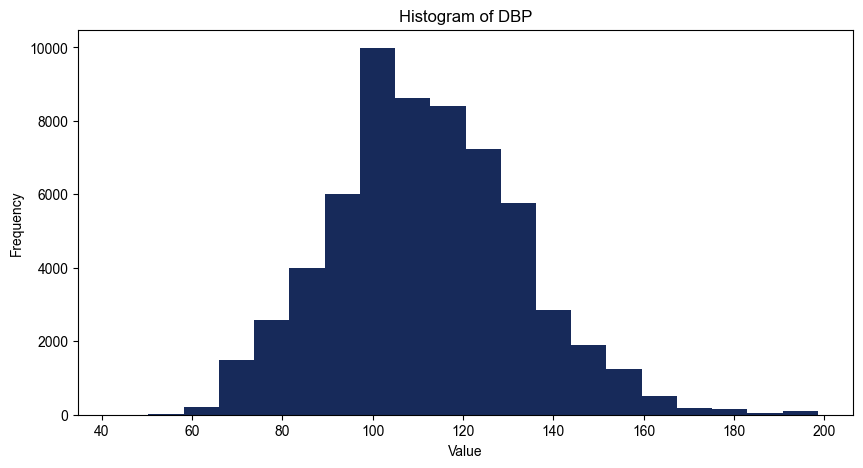

In [689]:
column_index = 1
column = bps_mat[:, 0]
column = column[np.isfinite(column)]

# Plot the histogram
plt.hist(column, bins=20)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of DBP')
plt.show()

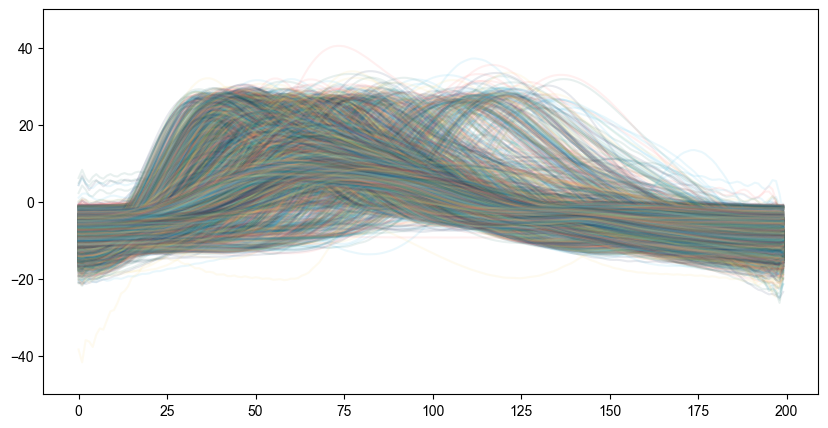

In [709]:
for i in range(1, 40000, 10):
    sns.lineplot(x= np.arange(200), y=segments[i, :], alpha=0.1)
    plt.ylim(-50, 50)

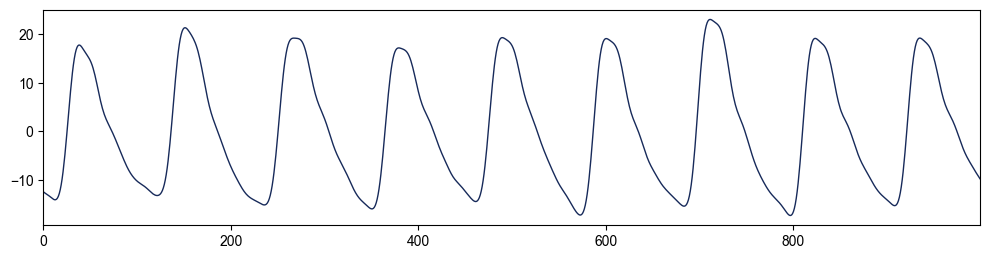

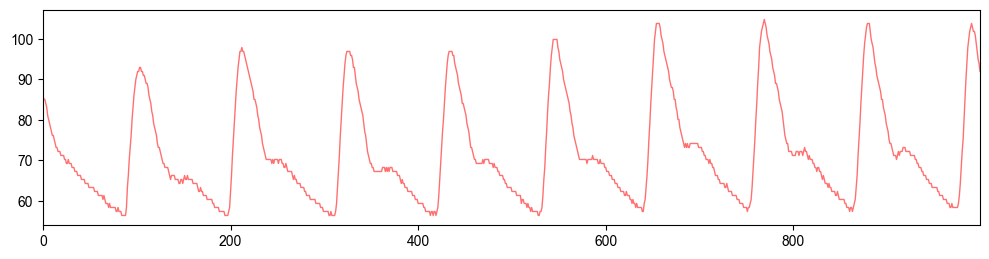

In [650]:
ppg = chunks_ppg[8]
ppg = ppg[0:1000]
art = chunks_art[8]
art = art[0:1000]
um(ta=None, tb = None, data=[ppg, art], t=np.arange(len(ppg)))


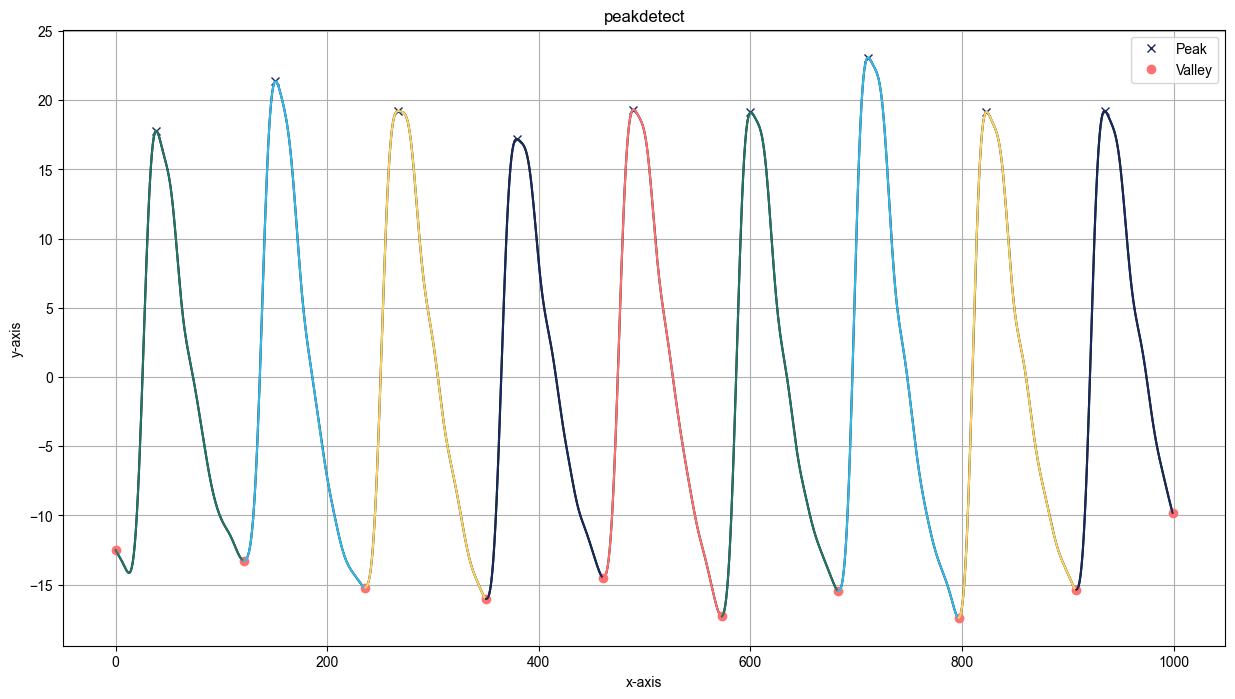

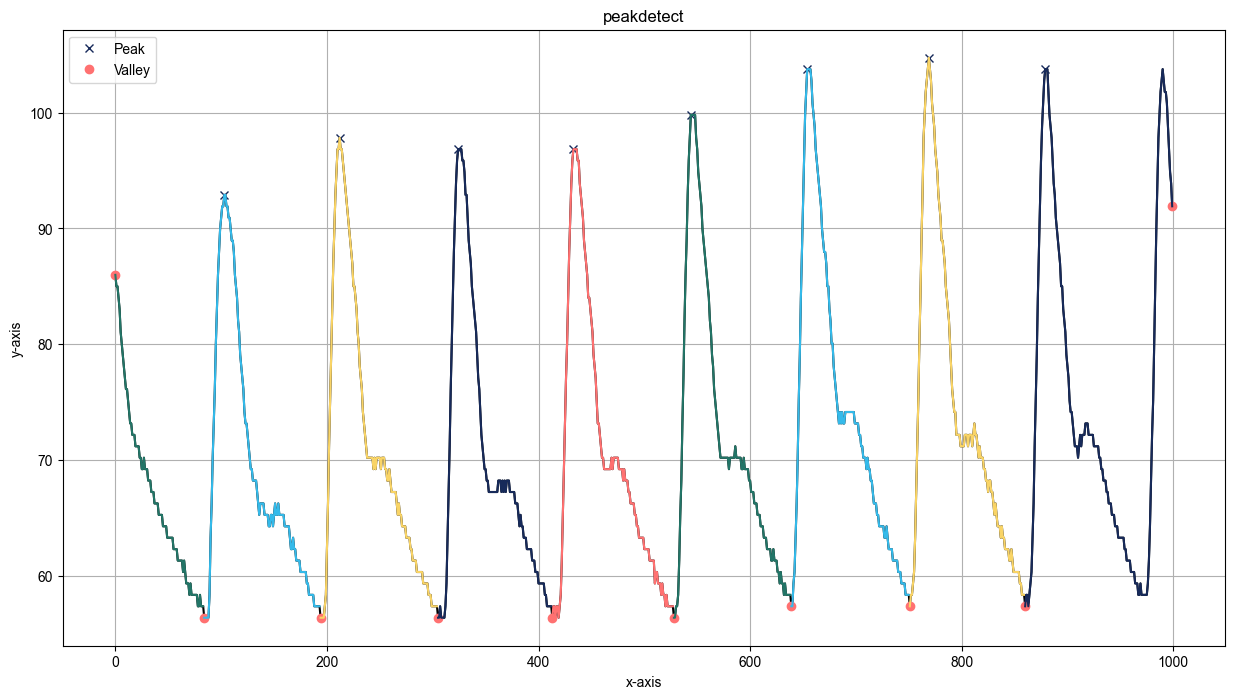

(None,
 <AxesSubplot:title={'center':'peakdetect'}, xlabel='x-axis', ylabel='y-axis'>)

In [651]:
    fp1 = findpeaks(method='peakdetect', lookahead=30, verbose=0)
    fp2 = findpeaks(method='peakdetect', lookahead=30, verbose=0)
    results_1 = fp1.fit(ppg)
    results_2 = fp2.fit(art)
    fp1.plot()
    fp2.plot()

In [652]:
#ppg
df1 = results_1["df"]
peaks1 = df1.loc[df1["peak"], "x"].values
troughs1 = df1.loc[df1["valley"], "x"].values
#art
df2 = results_2["df"]
peaks2 = df2.loc[df2["peak"], "x"].values
troughs2 = df2.loc[df2["valley"], "x"].values

array([103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76000214,
       103.76000214, 103.76000214, 103.76000214, 103.76

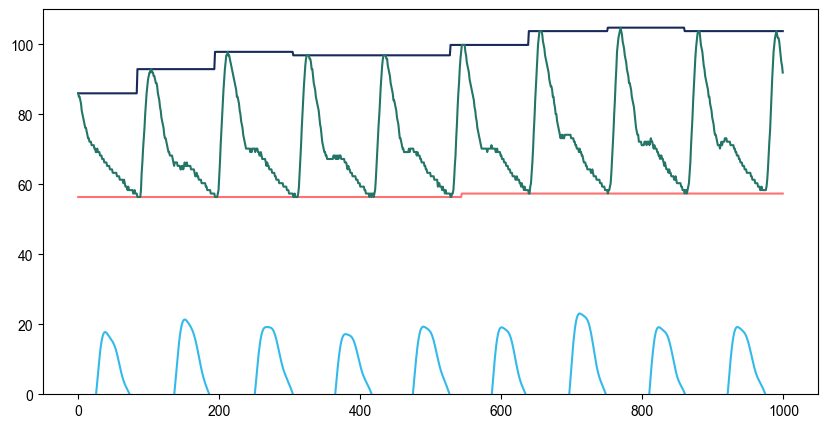

In [655]:
#get systolic blood pressures
dbp = fill_valleys(art, peaks2)
sbp = fill_peaks(art, troughs2)
plt.plot(sbp)
plt.plot(dbp)
plt.plot(art)
plt.plot(ppg)
plt.ylim([0, 110])
sbp[-100:]

In [656]:
cycles, bps = segment_ppg_cycles_resample(ppg, peaks1, troughs1, 50, 200, sbp, dbp)


In [619]:
args

array([ 57, 165, 275, 383, 494, 602, 710, 815])

In [658]:
np.shape(cycles)
np.shape(bps)


(7, 2)

In [601]:
bps

array([], dtype=float64)

In [598]:
np.shape(cycles)

(0,)

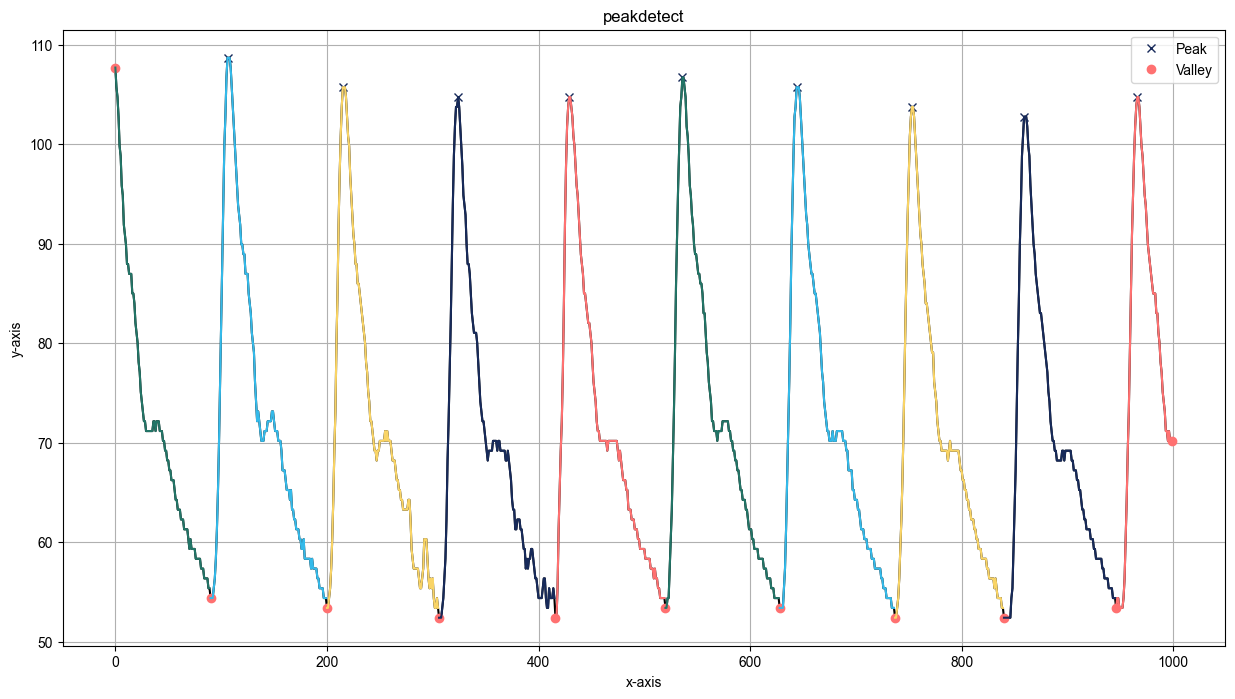

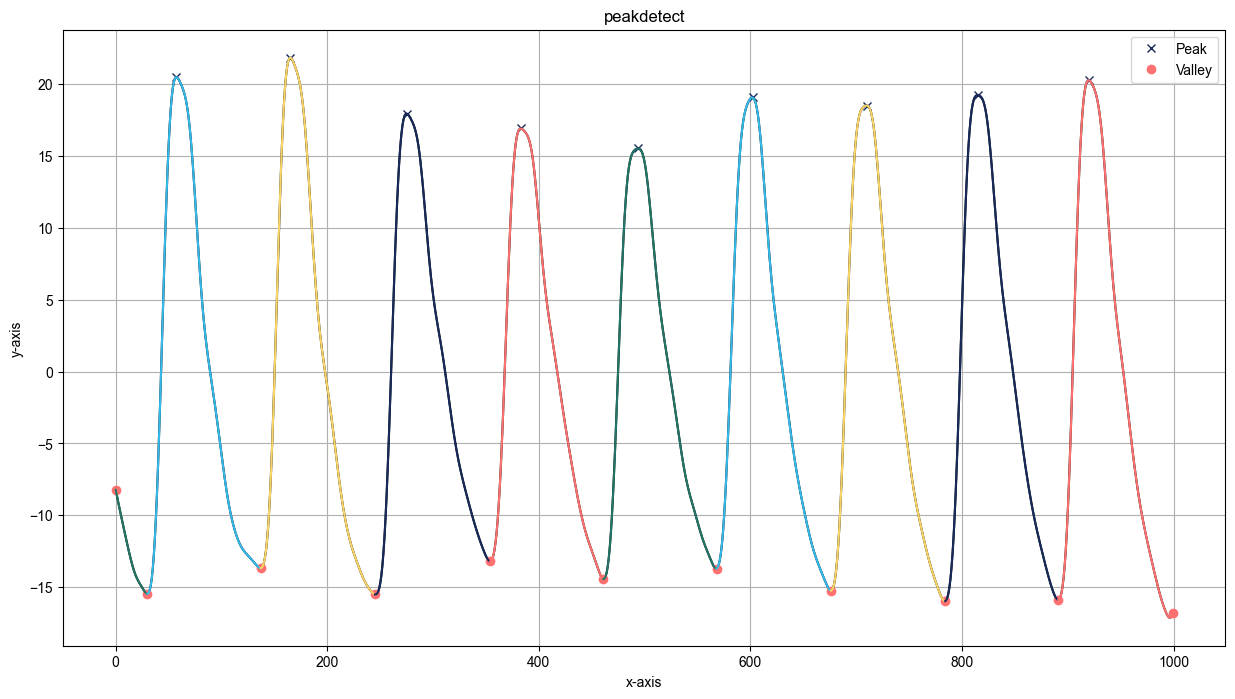

array([ 57, 165, 275, 383, 494, 602, 710, 815, 920])

In [411]:
fp2.plot()
fp1.plot()

In [ ]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt

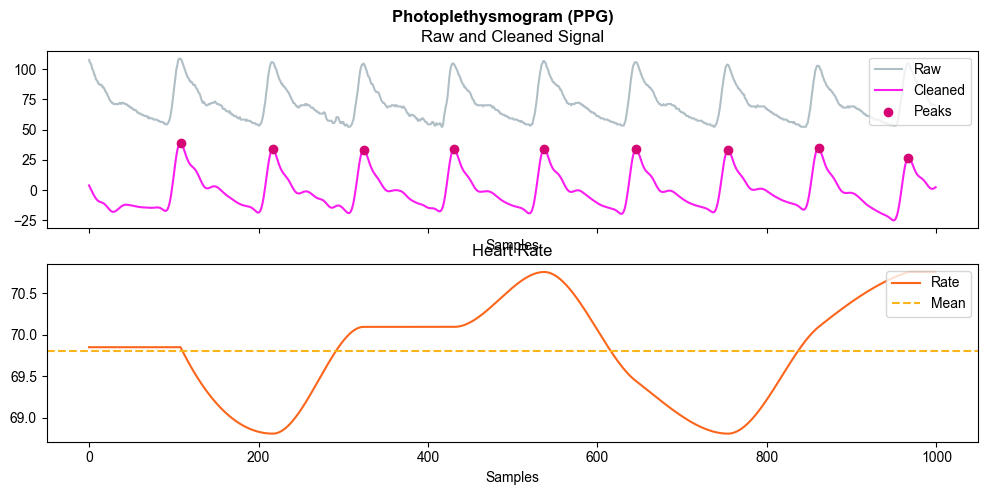

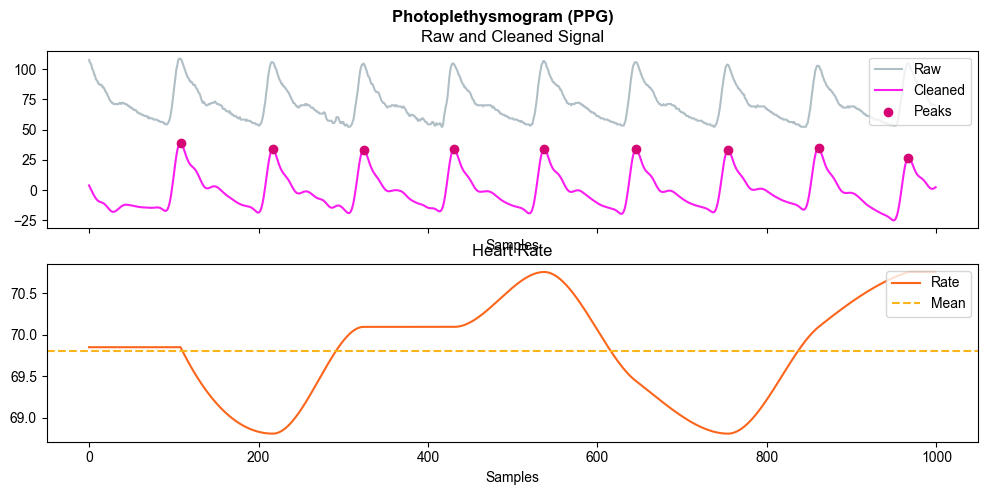

In [506]:
signals, info = nk.ppg_process(art, sampling_rate=125)
nk.ppg_plot(signals)

In [370]:
from findpeaks import findpeaks


In [578]:
cycles_mat = np.empty((1, 200))

for i in range(len(chunked_ppgm)):
    ppg = chunks_ppg[i]
    
    fp1 = findpeaks(method='peakdetect', lookahead=75, verbose=0)
    results_1 = fp1.fit(ppg)
    
    df = results_1["df"]
    peaks = df.loc[df["peak"], "x"].values
    troughs = df.loc[df["valley"], "x"].values
    cycles = segment_ppg_cycles_resample(ppg, peaks, troughs, 50, 200)
    
    cycles_mat = np.concatenate((cycles_mat, cycles), axis=0)
    
    print(np.shape(cycles_mat))



TypeError: segment_ppg_cycles_resample() missing 2 required positional arguments: 'sbps' and 'dbps'

In [355]:
np.shape(cycles_mat)

(12569, 200)

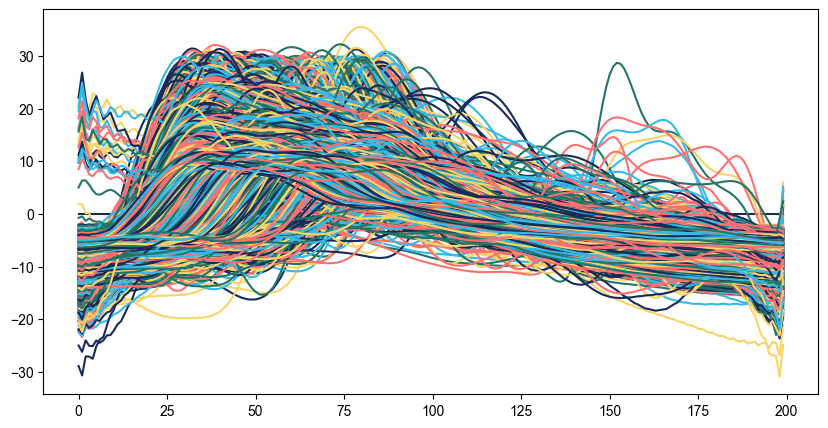

In [356]:
for cycle in cycles_mat:
    plt.plot(cycle)
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


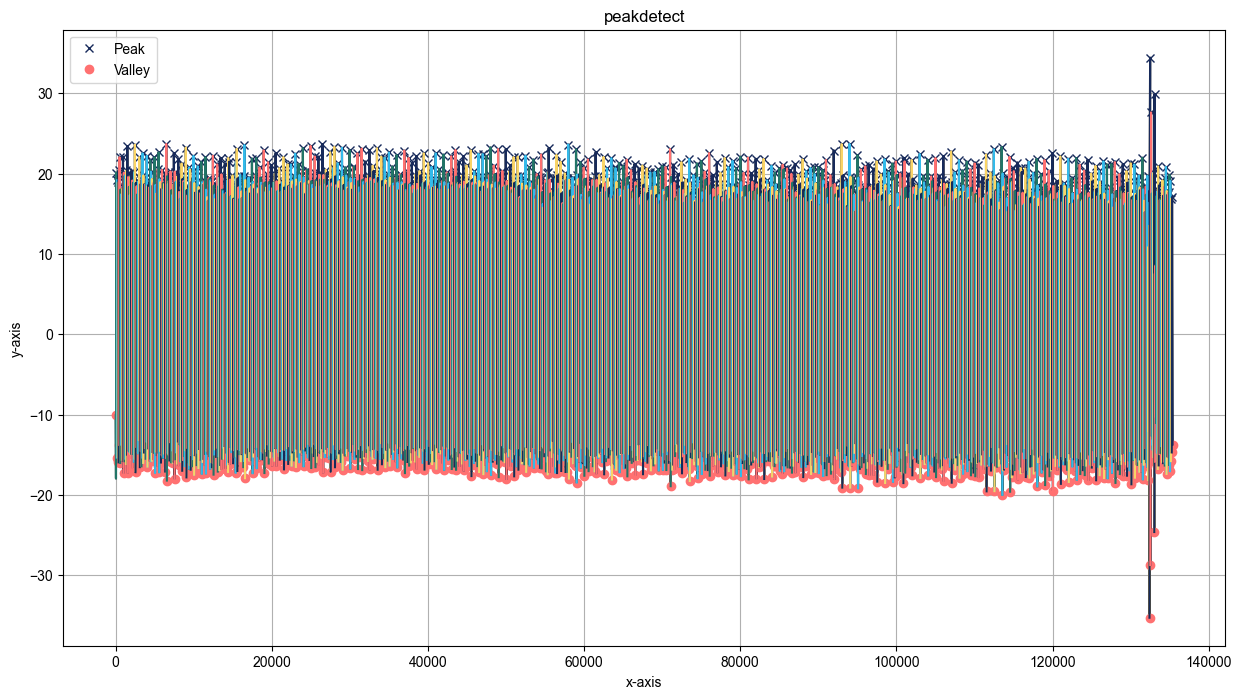

(None,
 <AxesSubplot:title={'center':'peakdetect'}, xlabel='x-axis', ylabel='y-axis'>)

In [337]:
    ppg = chunks_ppg[16]
    art = chunks_art[16]
    art = art[0:1000]
    ppg = ppg[0:1000]
    fp1 = findpeaks(method='peakdetect', lookahead=55)
    results_1 = fp1.fit(ppg)
    fp1.plot()

In [338]:
df = results_1["df"]
peaks = df.loc[df["peak"], "x"].values
troughs = df.loc[df["valley"], "x"].values


Too short
Too short


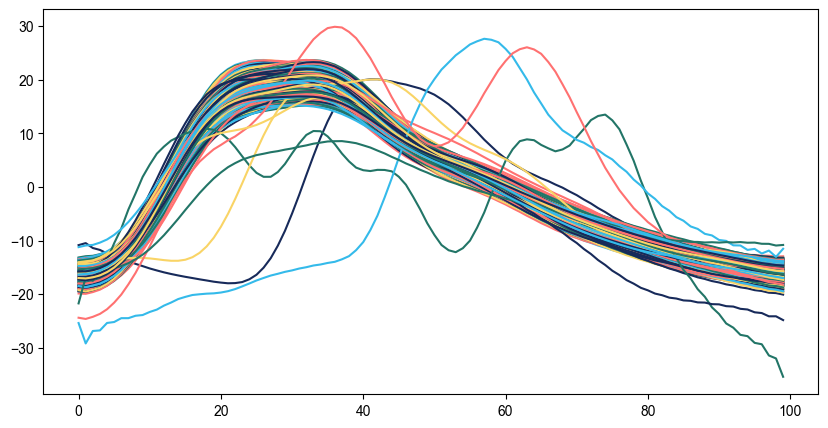

In [340]:
cycles_mat = segment_ppg_cycles_resample(ppg, peaks, troughs, 100, 100)

for cycle in cycles_mat:
    plt.plot(cycle)
plt.show()

-0.310596    48.462799
-0.302485    47.475399
-0.294374    47.475399
-0.286264    47.475399
-0.278153    47.475399
               ...    
 0.411265    66.237099
 0.419376    65.249603
 0.427487    64.262100
 0.435598    65.249603
 0.443709    64.262100
Name: Signal, Length: 94, dtype: float32

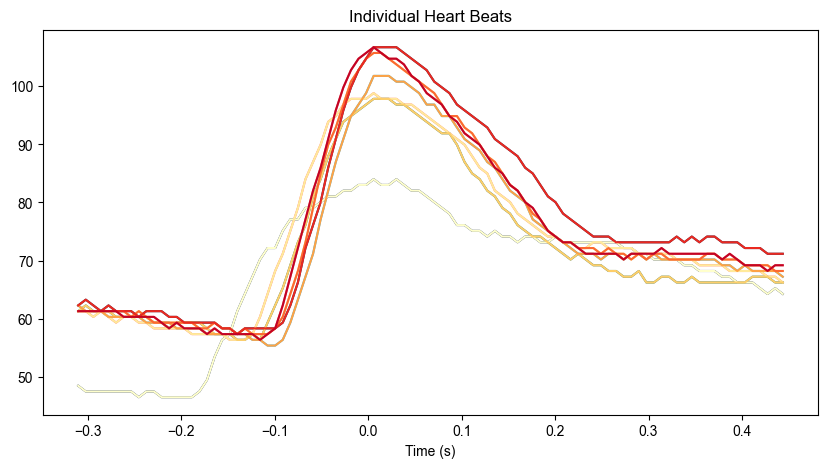

In [187]:
epochs = nk.ecg_segment(art, rpeaks=peaks, sampling_rate=125, show=True)
epochs["1"]["Signal"]

In [314]:
peak_valleys

,avg_peak,avg_valley
0,123.510002,84.505005
1,121.535004,85.986145
2,95.860947,84.505005
3,121.535004,92.898399
4,123.510002,89.935997
...,...,...
101,92.898262,76.605347
102,117.584999,76.605347
103,96.354500,81.048904
104,101.785706,79.073952


In [257]:
def segment_ppg2(ppg, fs):
    # Find PPG peaks
    peaks, _ = ss.find_peaks(ppg, distance=int(0.5*fs))

    # Initialize variables
    cycles = []
    window_size = 0
    prev_peak = 0
    
    # Loop through peaks and segment cycles
    for i, peak in enumerate(peaks):
        # Determine window size based on previous cycle duration
        if i > 0:
            window_size = int((peak - prev_peak) * 1.5)
        # If first peak, use a fixed window size
        else:
            window_size = int(0.8*fs)
        
        # Segment current cycle
        start = peak - window_size//2
        end = peak + window_size//2
        if start < 0:
            start = 0
        if end > len(ppg)-1:
            end = len(ppg)-1
        cycle = ppg[start:end]
        
        # Append cycle to list
        cycles.append(cycle)
        
        # Update previous peak
        prev_peak = peak
    
    # Plot the first five cycles
    fig, axs = plt.subplots(nrows=10, figsize=(10, 15))
    for i, ax in enumerate(axs):
        ax.plot(cycles[i+100])
        ax.set_title(f"Cycle {i+1}")
        ax.set_xlabel("Samples")
        ax.set_ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
        
    # Return cycles
    return cycles
